In [ ]:
!pip install langgraph
!pip install qdrant-client fastembed
!pip install langchain-google-genai
!pip install langchain-sambanova
!pip install ragas

In [5]:
import os
from google.colab import userdata
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient,models

In [58]:
dense_model = TextEmbedding(model_name="jinaai/jina-embeddings-v2-small-en")
sparse_model = SparseTextEmbedding(model_name="Qdrant/BM25")

In [59]:
collection_name = "casestudy"

In [60]:
client = QdrantClient(
    url = userdata.get("QDRANT_URL"),
    api_key = userdata.get("QDRANT_API_KEY"),
)

In [6]:
from typing import List, Dict, Any, TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_sambanova import ChatSambaNovaCloud
from langchain.schema import HumanMessage, SystemMessage

In [7]:
os.environ['SAMBANOVA_API_KEY'] = userdata.get("SAMBANOVA_API_KEY")
os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")

In [8]:
small_llm = ChatSambaNovaCloud(
    model="Meta-Llama-3.1-8B-Instruct",
    max_tokens=4096,
    temperature=0.0
)

large_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    max_tokens=None,
    temperature=0
)

In [49]:
class AgenticRAGState(TypedDict):
    query: str
    context: List[Dict[str, Any]]
    answer: str
    filter_conditions: Optional[Dict[str, Any]]

In [ ]:
def rewriter_agent(state: AgenticRAGState) -> AgenticRAGState:
    """Query optimization using small LLM"""
    query = state["query"]

    prompt = f"""You are an AI-powered Prompt Optimizer agent. Your sole purpose is to analyze a raw user query about Uber's internal policies and rewrite it into a clear, detailed, and structured query. This optimized query will be used by another agent to search a vector database of Uber's internal policy documents.

    Your response MUST be in Markdown format and only contain the Optimized Query. DO NOT use JSON or any other format.

    The raw user query will be provided below:
    {query}

    **CONTEXT:**
    - **Domain:** Uber's internal corporate policies, procedures, and guidelines.
    - **User:** An Uber employee who may not know the official terminology.
    - **Goal:** To produce an optimized query that retrieves the most comprehensive and accurate policy information.

    **CHAIN OF THOUGHT INSTRUCTIONS:**
    Follow these steps methodically in your "Chain of Thought" section:
    1. **Identify Core Intent:** What is the fundamental information the user is trying to find? Summarize it in one sentence.
    2. **Extract Key Entities & Keywords:** List the primary subjects, nouns, and potential policy names mentioned or implied in the query (e.g., "expense report," "WFH policy," "paternity leave," "travel," "stipend").
    3. **Disambiguate and Expand:** The user's query is likely incomplete. Brainstorm related sub-topics and questions that the user might also have. For example, if the query is "PTO," consider expanding to "PTO accrual rates," "blackout periods," "approval process," and "carry-over policy."
    4. **Infer User Persona and Context (if possible):** Is this likely a manager, an individual contributor, a new hire? Does the query imply a specific situation (e.g., preparing for a trip, having a child)? This can help focus the search.
    5. **Synthesize Search Strategy:** Briefly describe how you will structure the final optimized query based on the steps above. This involves combining the extracted entities and expanded topics into a coherent set of questions.

    **OPTIMIZED QUERY INSTRUCTIONS:**
    - The "Optimized Query" should be a comprehensive, well-structured prompt.
    - Use bullet points or numbered lists to break down the query into logical parts.
    - Frame the query as a request for specific information, covering the core intent and the expanded sub-topics.
    - Use both the user's original language and potential official policy terms to maximize search effectiveness.
    """

    response = small_llm.invoke([HumanMessage(content=prompt)])
    state["query"] = response.content.strip()

    return state

In [62]:
def search_retrieval(state: AgenticRAGState) -> AgenticRAGState:
    """Hybrid search - Retrieval process"""

    query = state["query"]
    filter_condition = state["filter_conditions"]

    dense_vectors = next(dense_model.embed([query]))
    sparse_vectors = next(sparse_model.embed([query]))

    prefetch = [
        models.Prefetch(query=dense_vectors, using="dense", limit=10),
        models.Prefetch(query=models.SparseVector(**sparse_vectors.as_object()), using="sparse", limit=10)
    ]

    results = client.query_points(
        collection_name,
        prefetch=prefetch,
        query=dense_vectors,
        using="dense",
        query_filter=filter_condition,
        with_payload=True,
        limit=5,
    )

    context = []
    for result in results.points:
        context.append({
            "content": result.payload["content"],
            "source": result.payload["source"],
            "page": result.payload.get("page", 0),
            "score": result.score,
            "chunk_keywords": result.payload.get('chunk_keywords', []),
        })

    state["context"] = context
    return state

In [63]:
def answer_generation(state: AgenticRAGState) -> AgenticRAGState:
    """Generate answer using large LLM"""

    query = state["query"]
    context = state["context"]

    context_text = ""
    for chunk in context:
        context_text += f"{chunk['source']} (Page {chunk['page']}): {chunk['content']}\n\n"

    prompt = f"""Answer this question using the policy context provided:
    Question: {query}
    Context:
    {context_text}
    Provide a clear, accurate answer citing the relevant sources.
    If query is not from the context, say "Not enough information available. Improve your query with relevant keywords".
    """

    response = large_llm.invoke([HumanMessage(content=prompt)])
    state["answer"] = response.content

    return state

In [64]:
workflow = StateGraph(AgenticRAGState)

In [65]:
workflow.add_node("rewriter_agent", rewriter_agent)
workflow.add_node("search_retrieval", search_retrieval)
workflow.add_node("answer_generation", answer_generation)

workflow.add_edge(START, "rewriter_agent")
workflow.add_edge("rewriter_agent", "search_retrieval")
workflow.add_edge("search_retrieval", "answer_generation")
workflow.add_edge("answer_generation", END)

In [66]:
graph = workflow.compile()

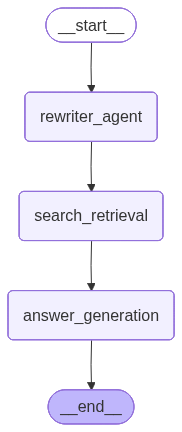

In [67]:
graph

In [68]:
result = graph.invoke({
        "query": "How does NEP 2020 propose to integrate vocational education into mainstream schooling?",
        "filter_conditions": None
    })

In [69]:
print(result['answer'])

Based on the provided policy context, NEP 2020 implements vocational education integration into the school curriculum primarily through the following principles and provisions:

1.  **Elimination of Hard Separations:** A fundamental principle guiding the education system is to have "no hard separations between arts and sciences, between curricular and extra-curricular activities, between vocational and academic streams, etc. in order to eliminate harmful hierarchies among, and silos between different areas of learning" (Page 5). This indicates a philosophical shift towards integrating vocational aspects rather than treating them as separate, inferior streams.

2.  **Flexibility and Student Choice in Secondary Stage:** In the Secondary Stage (Grades 9-12), students will have "greater flexibility and student choice of subjects." Specifically, students will have the option of "re-entering in the next phase to pursue vocational or any other courses available in Grades 11-12, including at a

## Evals

In [ ]:
!pip install pymupdf
!pip install rapidfuzz
!pip install langchain-openai

In [40]:
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

from langchain_community.document_loaders import PyMuPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

In [31]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [32]:
loader = PyMuPDFLoader("/content/data.pdf")

In [33]:
data = loader.load()

In [36]:
eval_embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

In [41]:
eval_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.9,
)

In [42]:
evaluator_llm = LangchainLLMWrapper(eval_llm)
evaluator_embeddings = LangchainEmbeddingsWrapper(eval_embeddings)

In [ ]:
generator = TestsetGenerator(llm=evaluator_llm, embedding_model=evaluator_embeddings)
dataset = generator.generate_with_langchain_docs(data, testset_size=10)

In [45]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How does the 2030 Agenda for Sustainable Devel...,[Introduction Education is fundamental for ach...,"The 2030 Agenda for Sustainable Development, s...",single_hop_specifc_query_synthesizer
1,Who was Susruta and what contributions did he ...,[National Education Policy 2020 4 Education Po...,Susruta was one of the great scholars produced...,single_hop_specifc_query_synthesizer
2,How does the Right of Children to Free and Com...,[Previous Policies The implementation of previ...,The Right of Children to Free and Compulsory E...,single_hop_specifc_query_synthesizer
3,Wht does the Ntional Educaion Policy 2020 say ...,"[National Education Policy 2020 7 Currently, c...",The National Education Policy 2020 includes ch...,single_hop_specifc_query_synthesizer
4,How does the National Education Policy 2020 ad...,[<1-hop>\n\nNational Education Policy 2020 46 ...,The National Education Policy 2020 addresses t...,multi_hop_abstract_query_synthesizer
5,How does the National Education Policy 2020 pr...,[<1-hop>\n\nNational Education Policy 2020 46 ...,The National Education Policy 2020 proposes to...,multi_hop_abstract_query_synthesizer
6,What does the National Education Policy 2020 p...,[<1-hop>\n\nNational Education Policy 2020 43 ...,The National Education Policy 2020 highlights ...,multi_hop_abstract_query_synthesizer
7,How does the National Education Policy 2020 ai...,[<1-hop>\n\nNational Education Policy 2020 48 ...,The National Education Policy 2020 aims to add...,multi_hop_abstract_query_synthesizer
8,How does the General Education Council (GEC) c...,[<1-hop>\n\nProfessional Standards for Teacher...,The General Education Council (GEC) contribute...,multi_hop_specific_query_synthesizer
9,How does the National Education Policy 2020 ai...,[<1-hop>\n\nNational Education Policy 2020 46 ...,The National Education Policy 2020 envisions a...,multi_hop_specific_query_synthesizer


In [47]:
dataset.to_pandas().to_csv("data.csv",index=False)

## LLM as a Judge

In [73]:
def get_context_relevance(context,question):
  instuctions = """You are a teacher grading a quiz.
  You will be given a QUESTION and a set of FACTS provided by the student.

  Here is the grade criteria to follow:

  <criteria>
  (1) You goal is to identify FACTS that are completely unrelated to the QUESTION
  (2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant
  (3) It is OK if the facts have SOME information that is unrelated to the question as long as (2) is met
  </criteria>

  <instructions>
  Relevance:
  A relevance value of True means that the FACTS contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant.
  A relevance value of False means that the FACTS are completely unrelated to the QUESTION.
  Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
  Avoid simply stating the correct answer at the outset.
  </instructions>
  """

  relevant_document = "\n\n".join(doc['content'] for doc in context)

  # Context relevance (C|Q)
  eval_setup = f"FACTS: {relevant_document}\nQUESTION: {question}"

  prompt = [
        {"role": "system", "content": instuctions},
        {"role": "user", "content": eval_setup},
    ]
  grade = large_llm.invoke(prompt)

  return grade.content

In [75]:
cr = get_context_relevance(context=result['context'],question=result['query'])

In [76]:
print(cr)

**Relevance:** True

**Reasoning:**

1.  **Identify keywords in the QUESTION:** The key terms in the question are "NEP 2020," "implement," "vocational education," and "integration into school curriculum."
2.  **Scan FACTS for keywords/semantic matches:**
    *   The document title itself is "National Education Policy 2020."
    *   On page 5, under "The fundamental principles that will guide both the education system at large," there is a bullet point stating: "no hard separations between arts and sciences, between curricular and extra-curricular activities, between vocational and academic streams, etc. in order to eliminate harmful hierarchies among, and silos between different areas of learning;". This directly addresses the integration of vocational streams into the broader curriculum by removing barriers.
    *   On page 11, paragraph 3.5 mentions: "NIOS and State Open Schools will offer the following programmes in addition to the present programmes: ... vocational education course

In [80]:
def get_answer_relevance(question,answer):
  instuctions = """You are a teacher grading a quiz.
    You will be given a QUESTION and a STUDENT ANSWER.

    <criteria>
    Here is the grade criteria to follow:
    (1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
    (2) Ensure the STUDENT ANSWER helps to answer the QUESTION
    </criteria>

    <instructions>
    Relevance:
    A relevance value of True means that the student's answer meets all of the criteria.
    A relevance value of False means that the student's answer does not meet all of the criteria.
    Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
    Avoid simply stating the correct answer at the outset.
    </instructions>
  """

  eval_setup = f"QUESTION: {question}\nSTUDENT ANSWER: {answer}"
  prompt = [
        {"role": "system", "content": instuctions},
        {"role": "user", "content": eval_setup},
    ]
  grade = large_llm.invoke(prompt)

  return grade.content

In [81]:
ar = get_answer_relevance(question=result['query'],answer=result['answer'])

In [82]:
print(ar)

Relevance: True

**Reasoning:**

1.  **Analyze the Question:** The question asks "How does NEP 2020 implement vocational education integration into school curriculum?" This requires the student to identify specific mechanisms, principles, or strategies outlined in the policy for this integration.
2.  **Evaluate Criterion 1 (Concise and Relevant):**
    *   The student's answer is structured into distinct points, making it clear and relatively concise.
    *   Each point directly addresses a method or principle of implementation, such as eliminating hard separations, offering student choice, utilizing open schools, and establishing a dedicated committee. These are all highly relevant to "how" the integration is implemented.
    *   The concluding paragraph, while noting what the policy *doesn't* detail, is also relevant as it demonstrates the student's understanding of the scope of the provided information and doesn't introduce irrelevant content.
3.  **Evaluate Criterion 2 (Helps to An

In [87]:
from ragas import SingleTurnSample
from ragas.metrics import LLMContextPrecisionWithReference
from ragas.metrics import LLMContextPrecisionWithoutReference

In [89]:
def get_context_precision(context,question,answer):
  evaluator_llm = LangchainLLMWrapper(large_llm)

  context_precision = LLMContextPrecisionWithoutReference(llm=evaluator_llm)

  context = " ".join(doc['content'] for doc in context)

  eval = SingleTurnSample(
    user_input=question,
    response=answer,
    retrieved_contexts=[context],
  )

  return context_precision.single_turn_ascore(eval)

In [90]:
precision = get_context_precision(result['context'],result['query'],result['answer'])

In [91]:
await precision

0.9999999999